# Tutorial 2: Introduction to PyTorch

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)  
**Empty notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)

**Goal**: Learn the basics of PyTorch (Tensors, Computation graph, etc.)

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## The Basics of PyTorch

In [2]:
import torch
print("Using torch", torch.__version__)

Using torch 1.6.0


### Tensors
* Explain what a tensor is in PyTorch
* Try to show parallels to numpy

### Dynamic Computation Graph and Backpropagation
* Introduce the conept of a dynamic computation graph
* Give a mini examples (c = a + b)
* Show the automatic backward calculation

In [3]:
a = torch.zeros((1,))
a.requires_grad_()

b = torch.ones((1,))

c = a + b

print("a:", a)
print("b:", b)
print("c:", c)

a: tensor([0.], requires_grad=True)
b: tensor([1.])
c: tensor([1.], grad_fn=<AddBackward0>)


### GPU support
* Important difference to numpy: support of GPU operations
* Shortly say what a GPU is
* Explain why a GPU is crucial for NN training

In [4]:
gpu_avail = torch.cuda.is_available()
print("Is the GPU available? %s" % str(gpu_avail))

Is the GPU available? True


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Learning by example: Continuous XOR
* Introduce NN concepts in PyTorch by a simple example where we train a minimal neural network on the XOR task with a little twist.

### The model

In [6]:
import torch.nn as nn

#### nn.Parameter
* Explanation fo parameters in PyTorch

#### nn.Modules
* Explanation of modules
* Mention forward function

#### Simple classifier
* Build a minimal linear classifier with 4 hidden units and tanh activation

In [7]:
class SimpleClassifier(nn.Module):
    
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [8]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)

### The data

* Explanation and intro to `torch.utils.data` library

In [9]:
import torch.utils.data as data

#### The dataset class

* Explanation of PyTorch's dataset class
* Implementation of XOR dataset class

In [10]:
class XORDataset(data.Dataset):
    
    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()
        
    
    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)
        
        self.data = data
        self.label = label
        
    
    def __len__(self):
        return self.size
    
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [11]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.9467, 1.0383]), tensor(0))


In [12]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

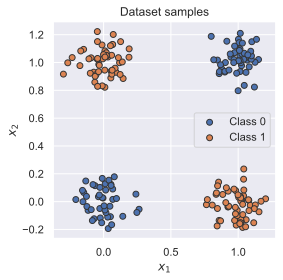

In [13]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

* Explanation of `torch.utils.data.DataLoader`
* How does batching work, and other relevant input parameters to the data loader

In [14]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [15]:
data_inputs, data_labels = next(iter(data_loader))
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.0101,  1.0395],
        [-0.2988,  0.9165],
        [ 0.0227,  1.0465],
        [ 0.9887,  0.9228],
        [-0.0735,  0.9306],
        [ 0.0505,  1.1206],
        [ 1.0716,  1.0549],
        [-0.0385,  0.0352]])
Data labels torch.Size([8]) 
 tensor([1, 1, 1, 0, 1, 1, 0, 0])


### Optimization

#### Loss modules
* List of loss modules in PyTorch
* Use BinaryCrossEntropy for our example

In [16]:
loss_module = nn.BCEWithLogitsLoss()

#### Stochastic Gradient Descent
* `torch.optim` library
* Use simple SGD

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Training

#### A simple training loop

In [18]:
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [19]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train()
    model.to(device)
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            loss = loss_module(preds, data_labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [20]:
train_model(model, optimizer, train_data_loader, loss_module)

#### Logging

#### Saving a model

### Evaluation

In [21]:
test_dataset = XORDataset(size=500)
test_data_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
def eval_model(model, data_loader):
    model.to(device) # Not needed if model already on device
    model.eval()
    TP, num_exmps = 0., 0.
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            pred_labels = (preds >= 0.5).long()
            TP += (pred_labels == data_labels).sum()
            num_exmps += data_labels.shape[0]
    acc = TP / num_exmps
    print("Accuracy of the model: %4.2f%%" % (100.0*acc))

In [23]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


#### Visualizing classification boundaries

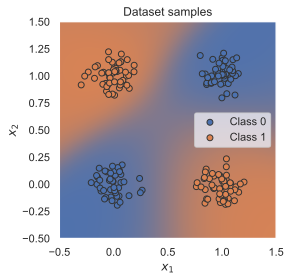

In [24]:
@torch.no_grad()
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = preds * c0[None,None] + (1 - preds) * c1[None,None]
    output_image = output_image.cpu().numpy()
    plt.imshow(output_image, origin='upper', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)

visualize_classification(model, dataset.data, dataset.label)
plt.show()